In [2]:
%pip install scikit-learn

                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB 187.9 kB/s eta 0:00:49
                                              0.0/9.2 MB 196.9 kB/s eta 0:00:47
                                              0.1/9.2 MB 374.1 kB/s eta 0:00:25
     -                                        0.2/9.2 MB 846.9 kB/s eta 0:00:11
     --                                       0.5/9.2 MB 1.7 MB/s eta 0:00:06
     ----                                     0.9/9.2 MB 2.5 MB/s eta 0:00:04
     -----                                    1.2/9.2 MB 3.0 MB/s eta 0:00:03
     ------                                   1.5/9.2 MB 3.3 MB/s eta 0:00:03
     -------                                  1.8/9.2 MB 3.7 MB/s eta 0:00:02
     ---------                                2.1/9.2 MB 3.8 MB/s eta 0:00:02

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, confusion_matrix

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

cuda:0


# Redes Convolucionales


![Image](https://www.unite.ai/wp-content/uploads/2019/12/Typical_cnn-1.png)


Las redes convolucionales (CNNs) se basan en el uso de una tecnica muy usada en el campo de computer vision tradicional, las **convoluciones** (https://en.wikipedia.org/wiki/Kernel_(image_processing), la idea es crear un filtro pequeño que pasamos por encima de toda la imagen y nos permite detectar distintos elementos (como son líneas verticales, horizontales, diagonales, circulos, etc). EL gran problema de las convoluciones es que para crear dichos filtros debemos poder especificar distintos valores (pesos) para cada región en el mismo. 

Cada filtro (tambien conocido como kernel) nos permite identificar algo en particular en la imágen, y aplicar un filtro al resultado de otro (u otros) nos permite obtener informacion de más alto nivel (como por ejemplo detectar ojos, ruedas, puertas, etc).

![Image](https://d2l.ai/_images/correlation.svg)

***

Las redes convolucionales nos dan una manera de no sólo aprender los vaores óptimos para dichos filtros (mediante backprop) sino tambien la posibilidad de hacerlo a escala usndo un número arbitrario de los mismos. Una gran ventaja que nos trae el uso de filtros, es el hecho de que requieren de un número muy chico de pesos a entrenar, lo que reduce el tamaño de nuestra red y nos permite entrenar mas rápido (o redes mas grandes y profundas con el mismo hardware).

Una cosa a notar en las redes convolucionales es el hecho de que las imágenes se van reduciendo en su tamaño a medida que fluyen por la red, esto se debe a la opeación de `maxpooling` que toma regiones (por lo general de 2x2) en nuestra imagen y se queda con el valor más alto en la zona, reduciendo asi el tamaño de la imagen. El resultado de aplicar un filtro de convolución a una imagen se llama `feature_map` y se puede pensar como otra imagen que describe la características de la original. 

***

Al final de nuestra red, necesitamos formar una predicción de la clase de nuestra imagen, por lo que tenemos que "achatar" estos feature maps y pasarlos por una (o varias) capas lineales que generen una predicción. Esto se puede ver como representar toda la informacion que conocemos de la imagen, como por ejemplo si tiene nariz, orejas, pelo, en un sólo vector; y decidir que ese vector representa a un perro.

***

Para empezar, volvemos a definir nuestros conjuntos de datos. Esta vez, sin hacer uso de ninguna transformacion sobre la imagen (mas que transformarla en un tensor).

In [7]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()
])

# Descargamos los datasets
# fashion_mnist_train_dataset = datasets.FashionMNIST(
#     "ruta_donde_guardar_datos",
#     download=True,
#     train=True,
#     transform=transform,
# )

mnist_train_dataset = datasets.FashionMNIST(
    "ruta_donde_guardar_datos",
    download=True,
    train=True,
    transform=transform,
)

# Separamos el train set en train y validation
train_set, val_set = torch.utils.data.random_split(
    mnist_train_dataset,
    [int(0.8 * len(mnist_train_dataset)), int(0.2 * len(mnist_train_dataset))],
)

mnist_test_dataset = datasets.FashionMNIST(
    "ruta_donde_guardar_datos",
    download=True,
    train=False,
    transform=transform,
)

# Creamos objetos DataLoader (https://pytorch.org/docs/stable/data.html) que nos va a permitir crear batches de data automaticamente.

# Cuantas imagenes obtener en cada iteracion!
BATCH_SIZE = 64

# Creamos los loaders
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,multiprocessing_context='spawn'
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2,multiprocessing_context='spawn'
)

test_loader = torch.utils.data.DataLoader(
    mnist_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2,multiprocessing_context='spawn'
)


### Modelo Convolucional

Igual que con el modelo FeedForward, para crear un modelo usando convoluciones necesitamos crear una clase, definir los metodos **init** y **forward** y especificar la arcquitectura y comportamiento de los componentes del modelo. 

En particular vamos a usar:

- capas convolucionales de 2D (https://pytorch.org/docs/stable/nn.html#conv2d) a las que tenemos que especificarles la cantidad de canales de entrada (1 para gris, 3 para color y X para el resultado de un filtro anterior), una cantidad de filtros a usar (out_channels), el tamaño de los mismos (kernel_size) y si aplicamos padding (relleno) o no (esto nos permite hacer convoluciones que no modifiquen el tamaño original de las imagenes). 

- Capas de maxpooling (https://pytorch.org/docs/stable/nn.html#maxpool2d) a las que tenemos que decirles el tamaño de la ventana a mirar y el largo del paso que deben tomar (stride).

- Finalmente tambien haremos uso de capas lineales y ReLUs como hicimos anteriormente.

## Modelo

Vamos a Implementar LeNet (cambiando tanh por ReLU) para comparar con el modelo lineal de la clase pasada.

***

LeNet:



![Image](https://media5.datahacker.rs/2018/11/leNet5_2.png)





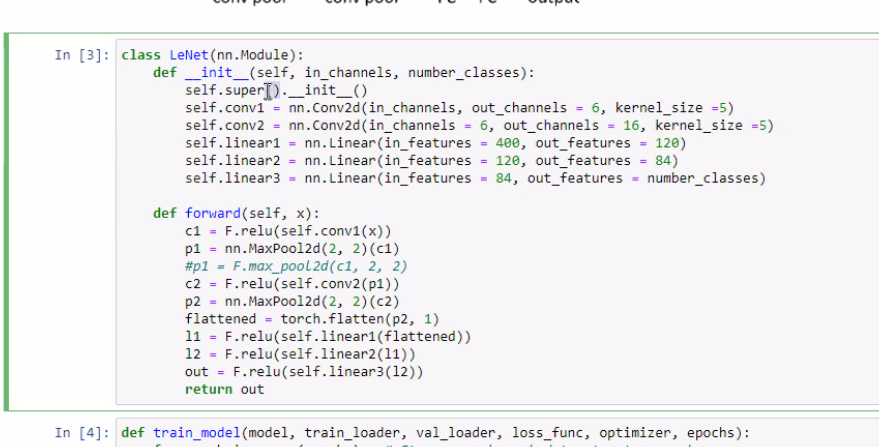

In [13]:
class LeNet(nn.Module):
  def __init__(self, in_channels, number_classes):
    super(LeNet,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.linear1 = nn.Linear(16*5*5, 120) # 400 in_features, 120 out_features
    self.linear2 = nn.Linear(120, 84) # 120 in_features, 84 out_features
    self.linear3 = nn.Linear(84, number_classes) # 84 in_features, 10 out_features
    
  def forward(self,x):
    c1 = F.relu(self.conv1(x))
    p1 = nn.MaxPool2d(2,2)(c1)
    c2 = F.relu(self.conv2(p1))
    p2 = nn.MaxPool2d(2,2)(c2)
    flattened = torch.flatten(p2,1)
    l1 = self.linear1(flattened)
    l2 = self.linear2(l1)
    out = F.relu(self.linear3(l2))
    return out
    


In [14]:
def train_model(model, train_loader, val_loader, loss_func, optimizer, epochs):
    for epoch in range(epochs):  # Iteramos sobre el dataset entero muchas veces

        running_loss = 0.0

        for i, data in enumerate(train_loader):
            # Nuestros datos son imagenes y la clase de cada una.
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Reseteamos los gradientes de los pesos del modelo.
            optimizer.zero_grad()

            # Obtenemos las predicciones para las nuevas imagenes llamando a nuestro modelo.
            predictions = model(images)

            # Calulamos el costo de nuestras predicciones respecto a la verdad
            loss = loss_func(predictions, labels)

            # Computamos los gradientes con backward y actualizamos los pesos con un optimizer.step()
            loss.backward()
            optimizer.step()

            # Estadísiticas
            running_loss += loss.item()
        print(f"Training Epoch: {epoch + 1}, - Loss: {running_loss / len(train_loader):.5f}")

        # test_epoch(model, val_loader, loss_func, "Validation")

    return model


In [ ]:
def test_epoch(model, test_loader, loss_func, name):
  pass

In [15]:
conv_model = LeNet(in_channels=1, number_classes=10).to(DEVICE)

LEARNING_RATE = 0.03

criterion = nn.CrossEntropyLoss().to(DEVICE)
conv_optimizer = optim.SGD(conv_model.parameters(), lr=LEARNING_RATE, momentum=0.9)

conv_model = train_model(conv_model, train_loader, val_loader, loss_func=criterion, optimizer=conv_optimizer, epochs=10)
# test_epoch(conv_model, test_loader, criterion, "Test")

Training Epoch: 1, - Loss: 0.87211
Training Epoch: 2, - Loss: 0.46343
Training Epoch: 3, - Loss: 0.40955
Training Epoch: 4, - Loss: 0.37683
Training Epoch: 5, - Loss: 0.35525
Training Epoch: 6, - Loss: 0.34256
Training Epoch: 7, - Loss: 0.33103
Training Epoch: 8, - Loss: 0.32420
Training Epoch: 9, - Loss: 0.31235
Training Epoch: 10, - Loss: 0.31155
